#### Experiment 2_all
- Saarbrucken(Near bahnhof region)
- AlAinRoad-DUBAI
- Bauhaus
- GLOBAS
- Hornbach

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
#reading files
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [38]:
#modulazrizing the whole code
img_path = "/home/akansh-i2sc/Desktop/Research@societal/data_parking_exp_2/Saar_Parking/*/*/*.tif"

from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path



#removing images with high black pixels
def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median


#removing images with high white pixels
def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white


### ML part
import pandas as pd
import datetime

def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    


def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

#make a function to read the image and convert it into a numpy array
def read_image(image_path):
    img = rioxarray.open_rasterio(image_path)
    img = img.data[0:3].transpose(1, 2, 0)
    return img

#make a function to resize the image
def resize_image(image, image_size):
    image = cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
    return image

#make a function to preprocess the images and convert them into numpy arrays
def preprocess_image(image_path, desired_size=128):
    img = read_image(image_path)
    img = resize_image(img, (desired_size, desired_size))
    img = img.reshape(-1, desired_size*desired_size*3)
    return img[0]




clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)
labels = label_csv(clean_3)
labels.head()

Initial size of dataset 500
Most common size of the dataset (4, 525, 554)
Final size of dataset(after removing faulty size images) 454
Final size of dataset(after removing faulty black pixels in images) 237
Final size of dataset(after removing faulty white pixels in images) 225
Class distribution in dataset: 0    153
1     72
Name: label, dtype: int64


image_path        day  label
0  /home/akansh-i2sc/Desktop/Research@societal/da...  Wednesday      0
1  /home/akansh-i2sc/Desktop/Research@societal/da...   Thursday      0
2  /home/akansh-i2sc/Desktop/Research@societal/da...     Friday      0
3  /home/akansh-i2sc/Desktop/Research@societal/da...     Sunday      1
4  /home/akansh-i2sc/Desktop/Research@societal/da...    Tuesday      0

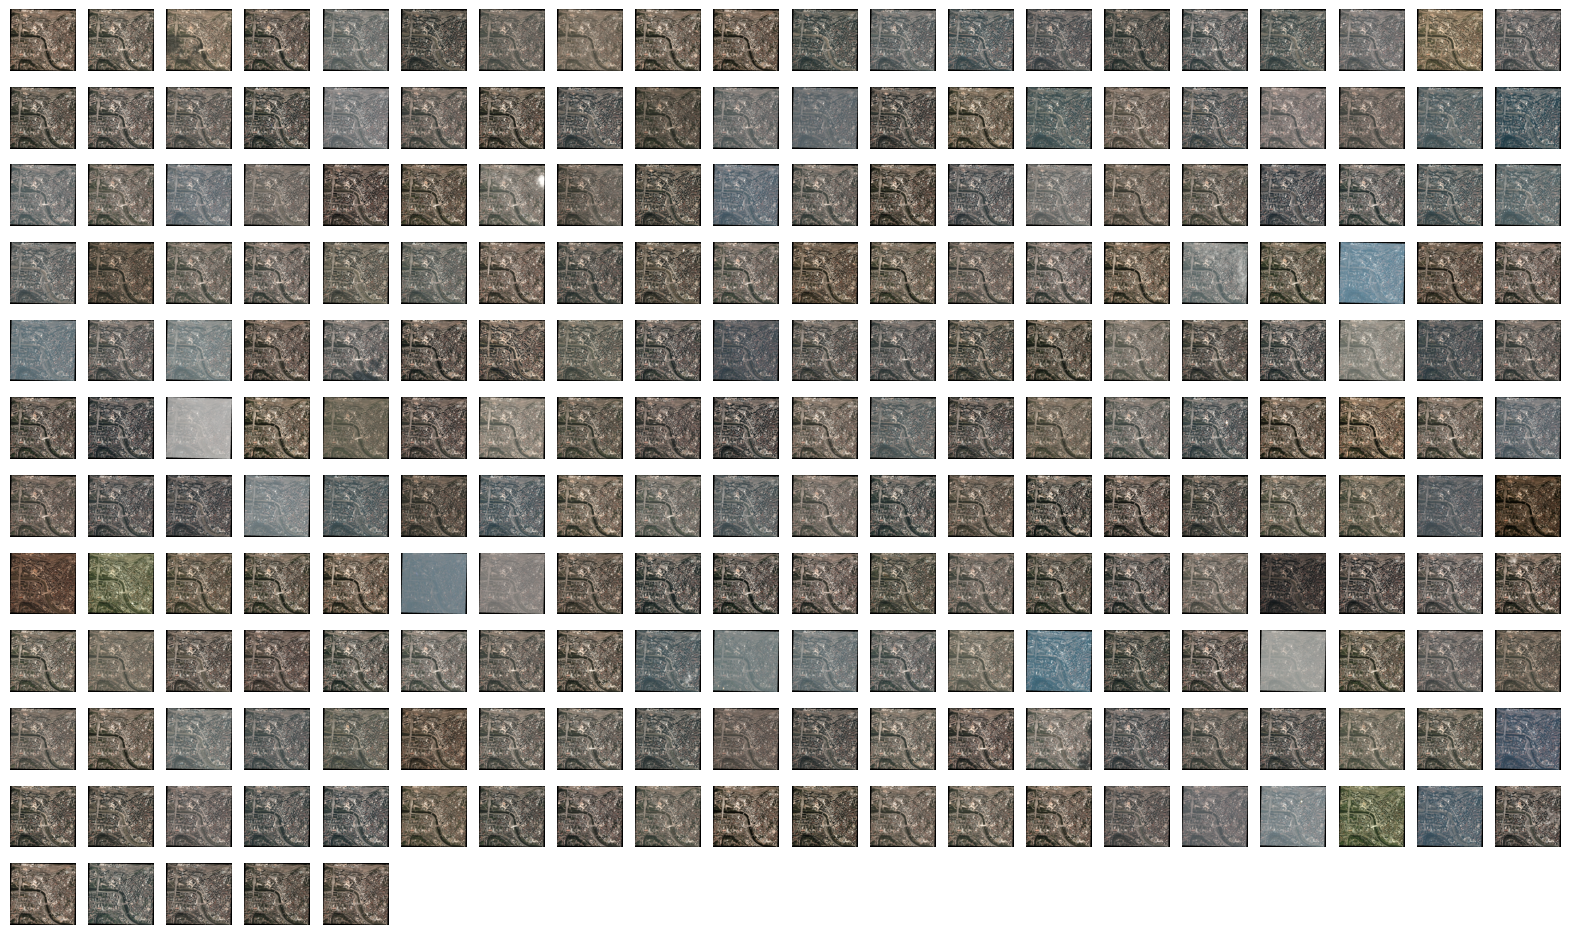

In [39]:
#plot all the images in the cleaned dataset in small tiles
plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score


df = label_csv(clean_3)
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

def train_model(X_train, y_train, X_test, y_test, experiment_name):
    print("Experiment:", experiment_name)
    models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC()
    }
    for i in models:
        model = models[i]
        print("Training model:", model.__class__.__name__)
        model.fit(X_train, y_train)
        print("Model trained.")
        y_pred = model.predict(X_test)
        print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
        print("AUC: {:.3f}".format(roc_auc_score(y_test, y_pred)))
        print("")
    print("Experiment completed.")

train_model(X_train, y_train, X_test, y_test, "Experiment 1: Saar_parking")


Class distribution in dataset: 0    153
1     72
Name: label, dtype: int64
Experiment: Experiment 1: Saar_parking
Training model: LogisticRegression
Model trained.
Accuracy: 0.822
AUC: 0.764

Training model: RandomForestClassifier
Model trained.
Accuracy: 0.733
AUC: 0.667

Training model: SVC
Model trained.
Accuracy: 0.644
AUC: 0.500

Experiment completed.


- AlAinRoad-DUBAI


Initial size of dataset 250
Most common size of the dataset (4, 164, 222)
Final size of dataset(after removing faulty size images) 248
Final size of dataset(after removing faulty black pixels in images) 220
Final size of dataset(after removing faulty white pixels in images) 140
Class distribution in dataset: 0    97
1    43
Name: label, dtype: int64
Experiment: Experiment 2: AlAinRoad-Dubai
Training model: LogisticRegression
Model trained.
Accuracy: 0.714
AUC: 0.644

Training model: RandomForestClassifier
Model trained.
Accuracy: 0.643
AUC: 0.567

Training model: SVC
Model trained.
Accuracy: 0.643
AUC: 0.500

Experiment completed.


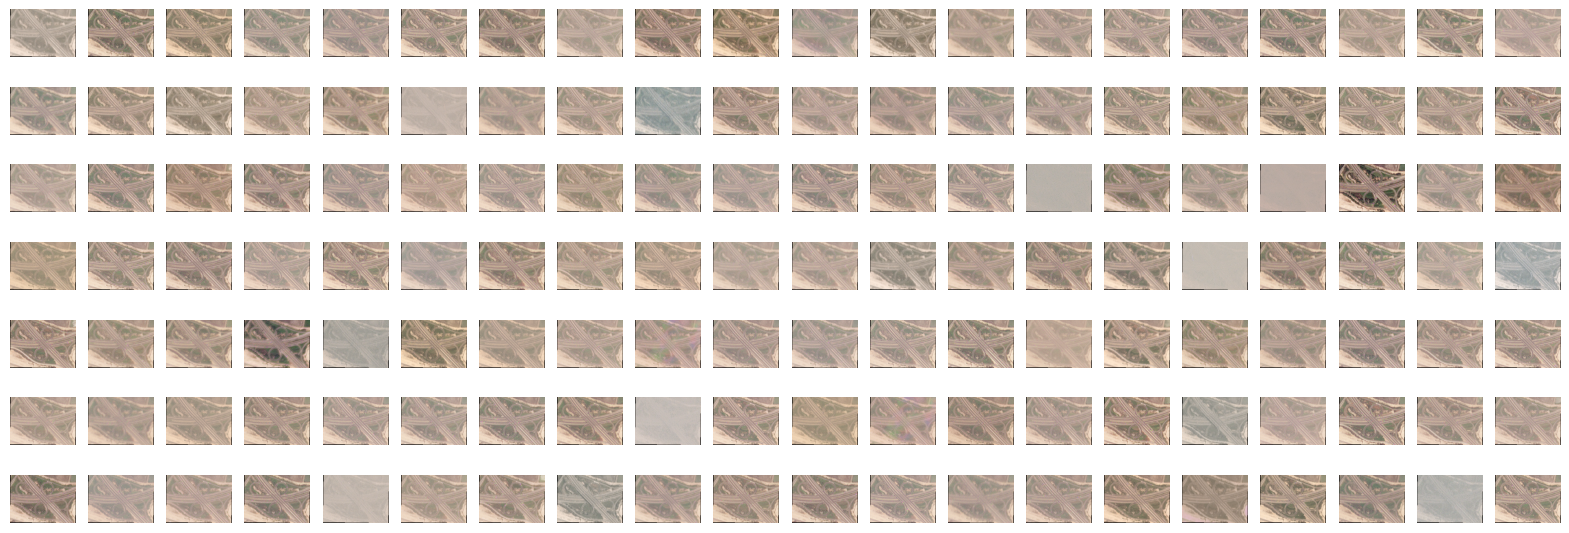

In [45]:
img_path = '/home/akansh-i2sc/Desktop/Research@societal/data_parking_exp_2/AlAinRoad-Dubai/*/*/*.tif'
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

    
df = label_csv(clean_3)
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

train_model(X_train, y_train, X_test, y_test, "Experiment 2: AlAinRoad-Dubai")

- Bauhaus

Initial size of dataset 133
Most common size of the dataset (4, 158, 169)
Final size of dataset(after removing faulty size images) 133
Final size of dataset(after removing faulty black pixels in images) 117
Final size of dataset(after removing faulty white pixels in images) 110
Class distribution in dataset: 0    81
1    29
Name: label, dtype: int64
Experiment: Experiment 3: Bauhaus
Training model: LogisticRegression
Model trained.
Accuracy: 0.864
AUC: 0.750

Training model: RandomForestClassifier
Model trained.
Accuracy: 0.773
AUC: 0.583

Training model: SVC
Model trained.
Accuracy: 0.727
AUC: 0.500

Experiment completed.


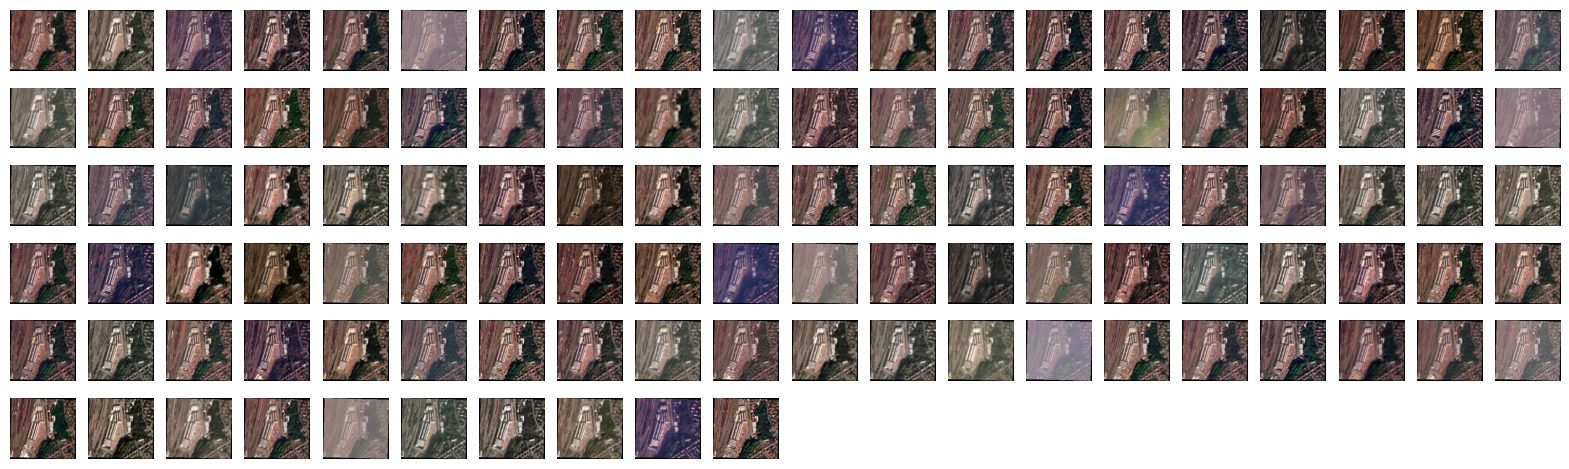

In [46]:
img_path = '/home/akansh-i2sc/Desktop/Research@societal/data_parking_exp_2/Bauhaus/*/*/*.tif'
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')


df = label_csv(clean_3)
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

train_model(X_train, y_train, X_test, y_test, "Experiment 3: Bauhaus")

- GLOBUS


Initial size of dataset 250
Most common size of the dataset (4, 277, 323)
Final size of dataset(after removing faulty size images) 243
Final size of dataset(after removing faulty black pixels in images) 203
Final size of dataset(after removing faulty white pixels in images) 110
Class distribution in dataset: 0    77
1    33
Name: label, dtype: int64
Experiment: Experiment 1: Globus
Training model: LogisticRegression
Model trained.
Accuracy: 0.864
AUC: 0.841

Training model: RandomForestClassifier
Model trained.
Accuracy: 0.864
AUC: 0.771

Training model: SVC
Model trained.
Accuracy: 0.773
AUC: 0.500

Experiment completed.


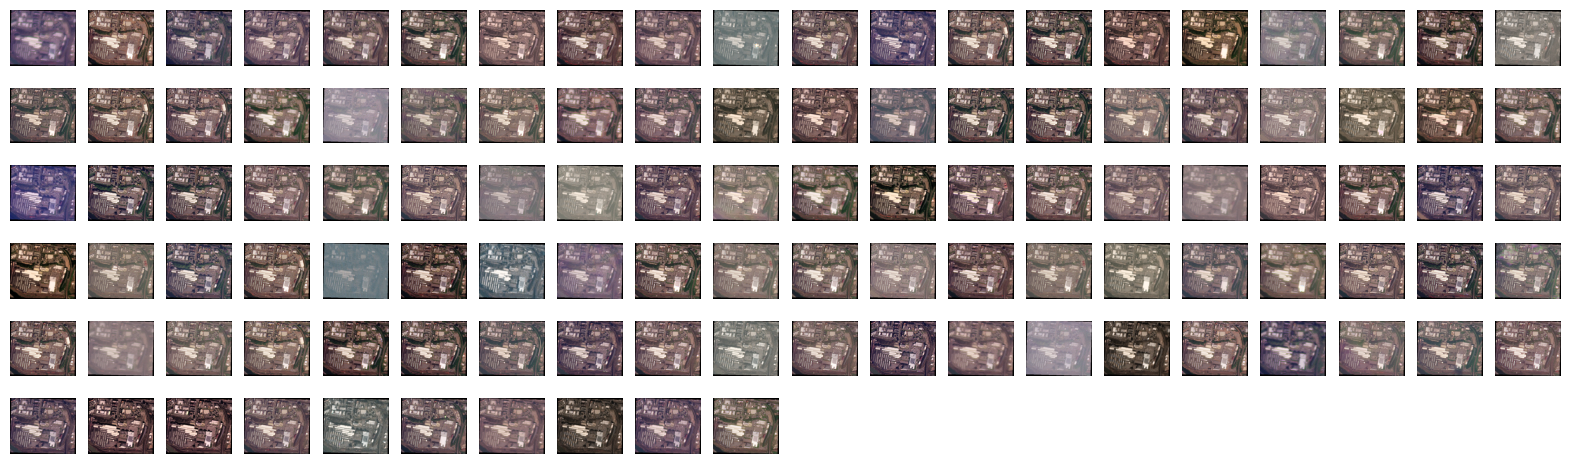

In [47]:
img_path = '/home/akansh-i2sc/Desktop/Research@societal/data_parking_exp_2/Globus/*/*/*.tif'
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')


df = label_csv(clean_3)
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

train_model(X_train, y_train, X_test, y_test, "Experiment 3: Globus")

- Hornbach

Initial size of dataset 250
Most common size of the dataset (4, 277, 323)
Final size of dataset(after removing faulty size images) 243
Final size of dataset(after removing faulty black pixels in images) 203
Final size of dataset(after removing faulty white pixels in images) 110
Class distribution in dataset: 0    77
1    33
Name: label, dtype: int64
Experiment: Experiment 5: Hornbach
Training model: LogisticRegression
Model trained.
Accuracy: 0.864
AUC: 0.841

Training model: RandomForestClassifier
Model trained.
Accuracy: 0.864
AUC: 0.771

Training model: SVC
Model trained.
Accuracy: 0.773
AUC: 0.500

Experiment completed.


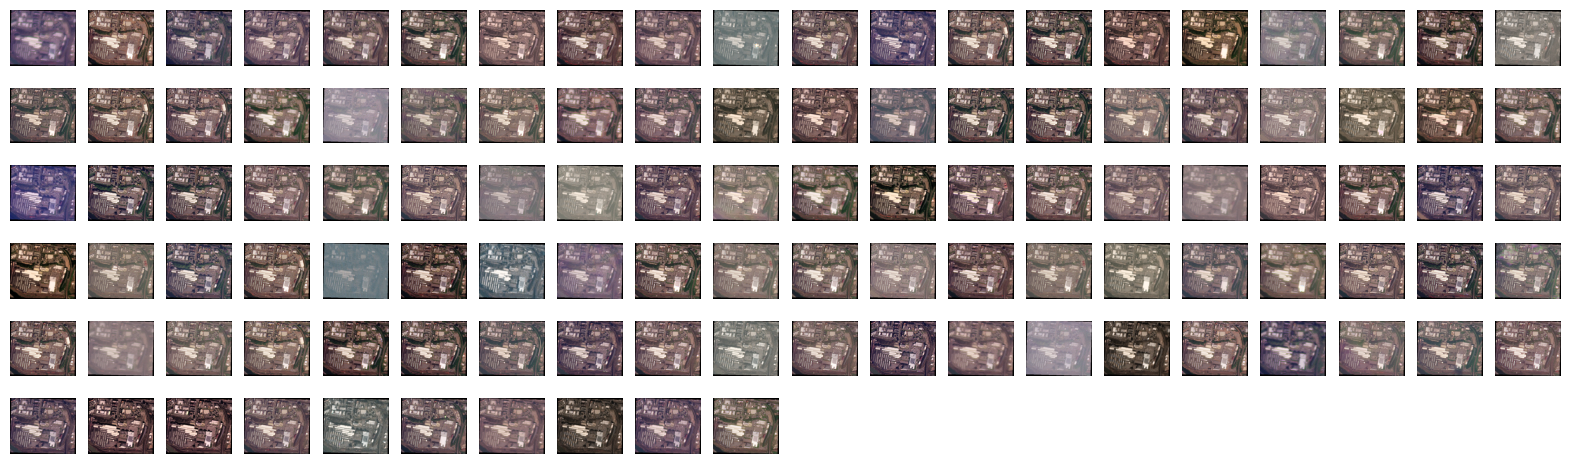

In [48]:
img_path = '/home/akansh-i2sc/Desktop/Research@societal/data_parking_exp_2/Globus/*/*/*.tif'
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(20,20,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')


df = label_csv(clean_3)
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

train_model(X_train, y_train, X_test, y_test, "Experiment 5: Hornbach")